In [ ]:
# 以下是我《面向对象的程序设计》课程的作业：评估利用机器学习回归模型预测掺杂氧化物负极材料容量的效果
# 变量说明：
# elements: 掺杂离子名称  en：掺杂元素电负性  ratio：掺杂离子与钛离子的比例  
# radius：掺杂离子半径  state：掺杂离子价态  rc：共价单键键长
# feo：形成能  Mweight：掺杂后的相对分子质量  low：测试过程中的最低电压  high：测试过程中的最高电压
# capacity：充放电比容量

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

In [48]:
# 读取数据集
final_data_csv = "./datasets.csv"  
headers = ["elements", "en", "ratio", "radius", "state", "rc", "feo", "Mweight", "low", "high", "capacity"]
df = pd.read_csv(final_data_csv, header=0, names=headers)
print(df.head(10))

  elements    en  ratio  radius  state    rc    feo  Mweight  low  high  \
0     Mg2+  1.31   0.02   0.072      2  1.39  601.6   79.428  0.8   2.8   
1     Mg2+  1.31   0.02   0.072      2  1.39  601.6   79.428  0.8   2.8   
2     Mg2+  1.31   0.02   0.072      2  1.39  601.6   79.428  0.8   2.8   
3     Mg2+  1.31   0.01   0.072      2  1.39  601.6   79.664  0.8   2.8   
4     Mg2+  1.31   0.01   0.072      2  1.39  601.6   79.664  0.8   2.8   
5     Mg2+  1.31   0.01   0.072      2  1.39  601.6   79.664  0.8   2.8   
6     Mg2+  1.31   0.04   0.072      2  1.39  601.6   78.956  0.8   2.8   
7     Mg2+  1.31   0.04   0.072      2  1.39  601.6   78.956  0.8   2.8   
8     Mg2+  1.31   0.04   0.072      2  1.39  601.6   78.956  0.8   2.8   
9     Sn4+  1.96   0.03   0.069      4  1.40  290.4   82.024  1.0   3.0   

   capacity  
0       160  
1       155  
2       140  
3       163  
4       152  
5       136  
6       159  
7       139  
8       110  
9       266  


In [49]:
# 定义变量类型
df['elements'] = df['elements'].astype('object')
df['state']=df['state'].astype('category')

print(df.dtypes)
print(df.head(2))

elements      object
en           float64
ratio        float64
radius       float64
state       category
rc           float64
feo          float64
Mweight      float64
low          float64
high         float64
capacity       int64
dtype: object
  elements    en  ratio  radius state    rc    feo  Mweight  low  high  \
0     Mg2+  1.31   0.02   0.072     2  1.39  601.6   79.428  0.8   2.8   
1     Mg2+  1.31   0.02   0.072     2  1.39  601.6   79.428  0.8   2.8   

   capacity  
0       160  
1       155  


In [50]:
target='capacity'
feat_cols = [c for c in df.columns.tolist() if c not in [target]]
X = df[feat_cols]
y = df[target]

cat_names = X.select_dtypes(include=['category']).columns.values.tolist()
num_names = X.select_dtypes(include=['float64', 'int64']).columns.values.tolist()
#X = pd.get_dummies(X, columns=cat_names)# Onehot
X.head(10)

,elements,en,ratio,radius,state,rc,feo,Mweight,low,high
0,Mg2+,1.31,0.02,0.072,2,1.39,601.6,79.428,0.8,2.8
1,Mg2+,1.31,0.02,0.072,2,1.39,601.6,79.428,0.8,2.8
2,Mg2+,1.31,0.02,0.072,2,1.39,601.6,79.428,0.8,2.8
3,Mg2+,1.31,0.01,0.072,2,1.39,601.6,79.664,0.8,2.8
4,Mg2+,1.31,0.01,0.072,2,1.39,601.6,79.664,0.8,2.8
5,Mg2+,1.31,0.01,0.072,2,1.39,601.6,79.664,0.8,2.8
6,Mg2+,1.31,0.04,0.072,2,1.39,601.6,78.956,0.8,2.8
7,Mg2+,1.31,0.04,0.072,2,1.39,601.6,78.956,0.8,2.8
8,Mg2+,1.31,0.04,0.072,2,1.39,601.6,78.956,0.8,2.8
9,Sn4+,1.96,0.03,0.069,4,1.40,290.4,82.024,1.0,3.0


In [51]:
all_samples=X.drop(columns='elements')
print(all_samples.head(3))

     en  ratio  radius state    rc    feo  Mweight  low  high
0  1.31   0.02   0.072     2  1.39  601.6   79.428  0.8   2.8
1  1.31   0.02   0.072     2  1.39  601.6   79.428  0.8   2.8
2  1.31   0.02   0.072     2  1.39  601.6   79.428  0.8   2.8


In [52]:
# 数据预处理
scaler = StandardScaler()
encoder = (OneHotEncoder(sparse= False))
preprocessor = ColumnTransformer(transformers=[('num', scaler, num_names), ('cat', encoder, cat_names)])
data_df = preprocessor.fit_transform(all_samples)
data_y_df = y[all_samples.index.values]
print(data_df)
print(data_y_df)

[[-1.76854687 -0.79690722  0.85592124 ...  0.          0.
   0.        ]
 [-1.76854687 -0.79690722  0.85592124 ...  0.          0.
   0.        ]
 [-1.76854687 -0.79690722  0.85592124 ...  0.          0.
   0.        ]
 ...
 [-0.5240543   1.06425165  0.23054225 ...  0.          1.
   0.        ]
 [ 0.80626535  0.59896193  0.23054225 ...  0.          0.
   0.        ]
 [ 0.80626535  0.59896193  0.23054225 ...  0.          0.
   0.        ]]
0      160
1      155
2      140
3      163
4      152
5      136
6      159
7      139
8      110
9      266
10     342
11     325
12     295
13     207
14     180
15     300
16     195
17     296
18     360
19     145
20     185
21     100
22     105
23     150
24      90
25     130
26     110
27     123
28     100
29     270
30     180
31     300
32     240
33     190
34     165
35      90
36      50
37     223
38     200
39     216
40     250
41     145
42     190
43     175
44     146
45      98
46     180
47     150
48      95
49     200
50    

In [53]:
# 拆分数据集
train_df, test_df, train_y_df, test_y_df = train_test_split(data_df, data_y_df, test_size= 0.2, random_state=42)

print(train_df)

[[ 0.67752474 -0.68058479 -2.68789302 ...  0.          0.
   0.        ]
 [ 1.02083304 -0.09897264  0.23054225 ...  1.          0.
   0.        ]
 [ 1.02083304  1.06425165  0.23054225 ...  1.          0.
   0.        ]
 ...
 [ 2.73737452 -1.02955208 -1.64559471 ...  0.          0.
   1.        ]
 [ 0.67752474  0.08714324 -2.68789302 ...  0.          0.
   0.        ]
 [-0.26657307 -0.09897264 -1.33290521 ...  0.          0.
   0.        ]]


In [ ]:
# 对训练集进行网格化搜索调参（以随机森林为例）
model = RandomForestRegressor(random_state=42, n_jobs=5)
n_estimatorss = list(range(10, 300, 20))
max_depths = list(range(1,11))
param_grid = dict(n_estimators = n_estimatorss, max_depth = max_depths)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, scoring = 'r2', cv = kfold, n_jobs=5)
grid_result = grid_search.fit(train_df, train_y_df)


print("Best: %f using %s" % (grid_result.best_score_, grid_search.best_params_))

In [ ]:
# 测试过程
model_trained = RandomForestRegressor(random_state= 42, n_estimators= 90, max_depth=10)
model_trained.fit(train_df, train_y_df)
score = model_trained.score(test_df, test_y_df)
y_pred = model_trained.predict(test_df)
from sklearn import metrics
MAE = metrics.mean_absolute_error(test_y_df, y_pred)
mse = metrics.mean_squared_error(test_y_df, y_pred)
RMSE = np.sqrt(mse)

print(MAE)
print(RMSE)
print(score)

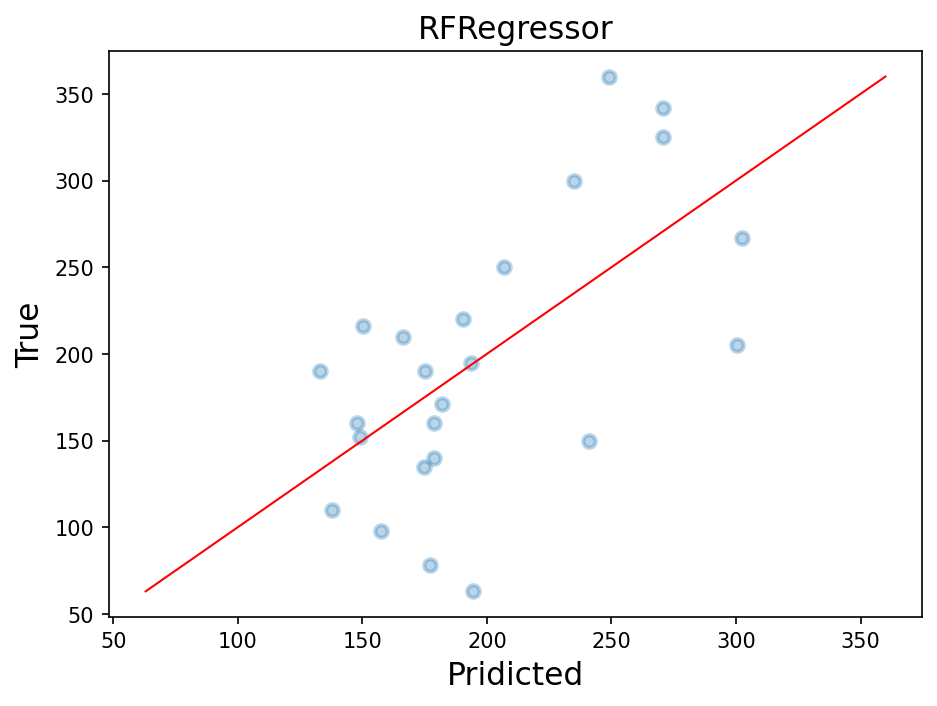

In [56]:
#回归结果做图
fig = plt.figure(figsize= (7, 5), dpi = 150)
plt.scatter(y_pred, test_y_df, lw= 2, alpha= 0.3)
plt.plot([min(test_y_df), max(test_y_df)], [min(test_y_df), max(test_y_df)],lw = 1, color = 'red')
plt.title('RFRegressor', fontsize=15)
plt.xlabel('Pridicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.show()